# Importing Libraries and loading data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.model_selection import GridSearchCV

In [2]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB, BernoulliNB, MultinomialNB, ComplementNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
#import adabosst
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score, f1_score


In [65]:
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

In [4]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2059 entries, 0 to 2058
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   ID              2059 non-null   int64 
 1   Candidate       2059 non-null   object
 2   Constituency ∇  2059 non-null   object
 3   Party           2059 non-null   object
 4   Criminal Case   2059 non-null   int64 
 5   Total Assets    2059 non-null   object
 6   Liabilities     2059 non-null   object
 7   state           2059 non-null   object
 8   Education       2059 non-null   object
dtypes: int64(2), object(7)
memory usage: 144.9+ KB


#### Initial Analysis

In [5]:
testing = [value.split()[-1] for value in df_train['Liabilities']]

In [6]:
s = set(testing)
s

{'0', 'Crore+', 'Hund+', 'Lac+', 'Thou+'}

In [7]:
def convert_to_numerical(value):
    if 'Crore+' in value:
        return int(float(value.split()[0])*10000000)
    elif 'Lac+' in value:
        return int(float(value.split()[0])*100000)
    elif 'Thou+' in value:
        return int(float(value.split()[0])*1000)
    elif 'Hund+' in value:
        return int(float(value.split()[0])*100)
    else:
        return int(value)
    
def apply_log(value):
    if value == 0:
        return 0
    return np.log(convert_to_numerical(value))

df_train['Total Assets'] = df_train['Total Assets'].apply(convert_to_numerical)
df_train['Liabilities'] = df_train['Liabilities'].apply(convert_to_numerical)

In [8]:
# # Select all columns except 'Education'
# col_not_convert = ['ID', 'Education', 'Candidate', 'Constituency ∇', 'Criminal Case', 'Liabilities', 'Total Assets',]
# cols_to_convert = df_train.columns.difference(col_not_convert)

# # Convert categorical data to one-hot encoding
# df_train_encoded = pd.get_dummies(df_train, columns=cols_to_convert)


In [9]:
df_train['Total Assets'].value_counts()

Total Assets
10000000      274
20000000      229
0             189
30000000      135
40000000      132
             ... 
450000000       1
1120000000      1
6680000000      1
3630000000      1
3120000000      1
Name: count, Length: 210, dtype: int64

In [10]:
df_train['Liabilities'].corr(df_train['Criminal Case'])

-0.000980801656310423

In [11]:
df_train['Liabilities'].corr(df_train['Total Assets'])

0.5975075932487341

In [12]:
#correlation between total assets and criminal cases
df_train['Total Assets'].corr(df_train['Criminal Case'])

-0.01298533729036144

In [13]:
df_train['Criminal Case'].value_counts()

Criminal Case
0     1135
1      368
2      165
3      102
4       68
5       53
6       36
7       32
8       17
9       16
10       9
12       7
11       7
13       5
18       5
16       4
22       4
25       3
14       3
38       2
29       2
52       2
19       2
30       1
43       1
24       1
49       1
17       1
87       1
23       1
15       1
26       1
27       1
73       1
34       1
Name: count, dtype: int64

In [14]:
#df_train.drop(['Criminal Case','Total Assets'],inplace=True,axis=1)

In [15]:
df_train.head()

,ID,Candidate,Constituency ∇,Party,Criminal Case,Total Assets,Liabilities,state,Education
0,0,M.K. Mohan,ANNA NAGAR,DMK,4,2110000000,20000000,TAMIL NADU,8th Pass
1,1,Khatik Ramesh Prasad,KARERA (SC),BJP,0,10000000,0,MADHYA PRADESH,12th Pass
2,2,Dr. Mantar Gowda,MADIKERI,INC,0,70000000,2200000,KARNATAKA,Post Graduate
3,3,Kundan Kumar,BEGUSARAI,BJP,0,90000000,2400000,BIHAR,Post Graduate
4,4,Swapan Majumder,BANGAON DAKSHIN (SC),BJP,2,20000000,6100000,WEST BENGAL,8th Pass


In [16]:
df_train['Party'].value_counts()

Party
BJP                         862
INC                         365
AITC                        130
AAP                          94
YSRCP                        86
DMK                          73
BJD                          65
SP                           62
CPI(M)                       43
RJD                          42
IND                          38
NCP                          34
AIADMK                       34
JD(U)                        32
SHS                          29
NPP                          20
JMM                          14
NDPP                          9
TDP                           8
JD(S)                         7
Sikkim Krantikari Morcha      5
CPI                           4
Tipra Motha Party             3
Name: count, dtype: int64

# Data Analysis

## Analysing Crimal Cases


<Axes: xlabel='Criminal Case'>

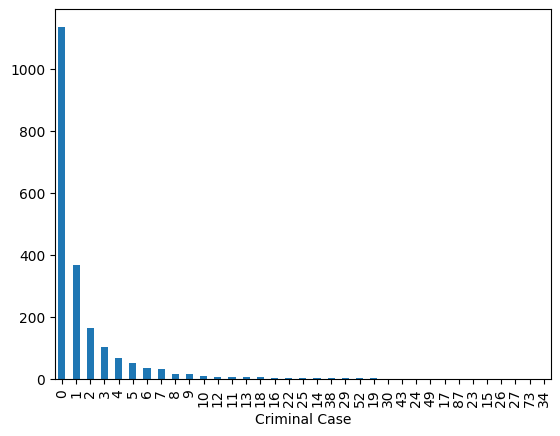

In [17]:
df_train['Criminal Case'].value_counts().plot(kind='bar')

### By Party

##### Criminal Cases in each party

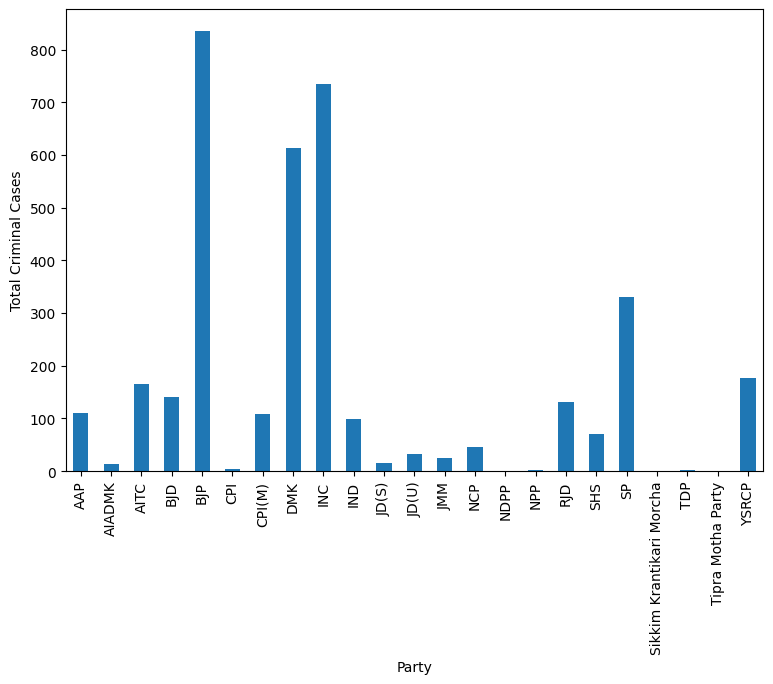

In [18]:
# Total criminal case in each party
plt.figure(figsize=(9,6))
df_train.groupby('Party')['Criminal Case'].sum().plot(kind='bar')
plt.xlabel('Party')
plt.ylabel('Total Criminal Cases')
plt.savefig('Images/criminal_cases_party.png')
plt.show()


##### Average Criminal case per candidate in each party

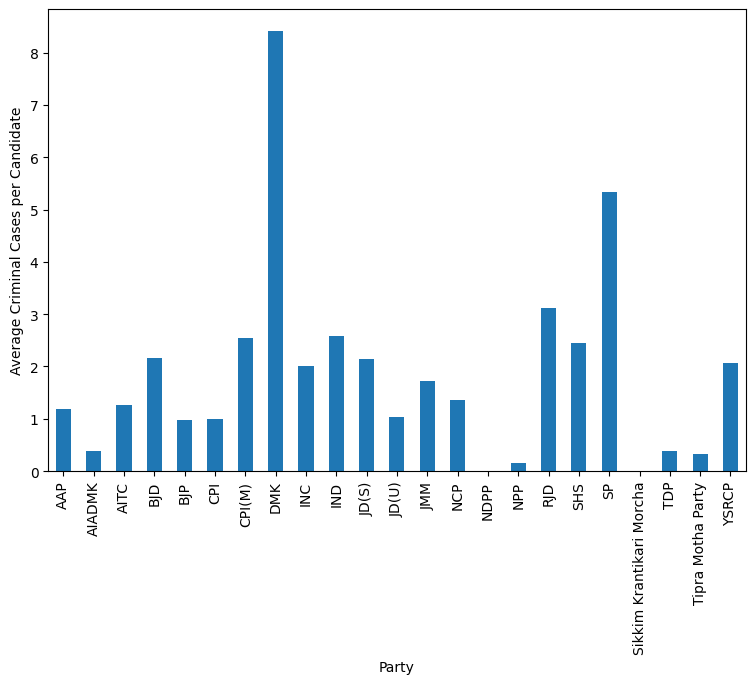

In [19]:
#avg Criminal case per candidate grouped by party
plt.figure(figsize=(9,6))
df_train.groupby('Party')['Criminal Case'].mean().plot(kind='bar')
plt.xlabel('Party')
plt.ylabel('Average Criminal Cases per Candidate')
plt.savefig('Images/avg_criminal_cases_party.png')
plt.show()


##### Percentage of Candidates having more than 3 criminal cases

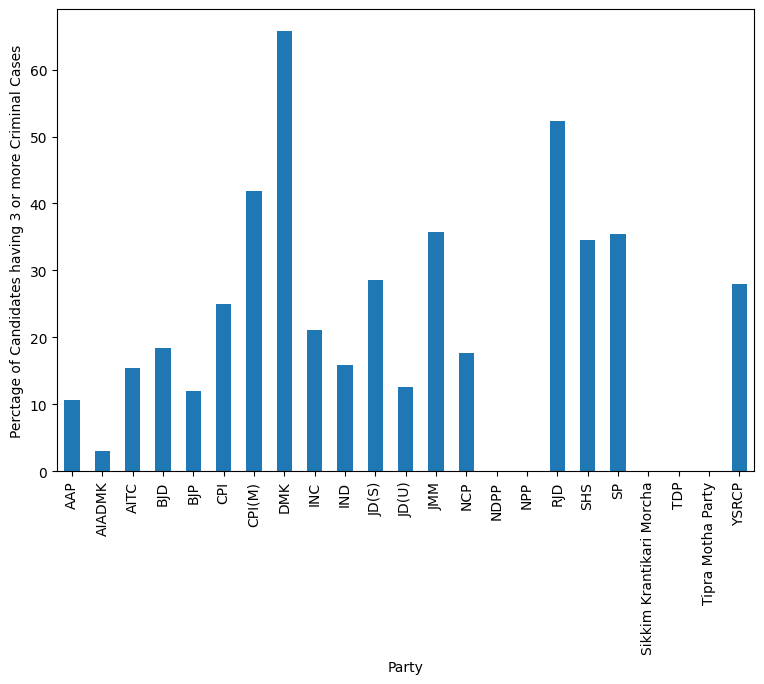

In [20]:
# Candidates having more than 3 criminal cases grouped by party


total_person_byparty = df_train.groupby('Party')['Candidate'].count()
data = df_train[df_train['Criminal Case'] >= 3].groupby('Party')['Criminal Case'].count()
data = data/total_person_byparty * 100

plt.figure(figsize=(9,6))
data.plot(kind='bar')
plt.xlabel('Party')
plt.ylabel('Perctage of Candidates having 3 or more Criminal Cases')
plt.savefig('Images/more_than_3_criminal_party.png')
plt.show()


### By State

##### Criminal Case in each State

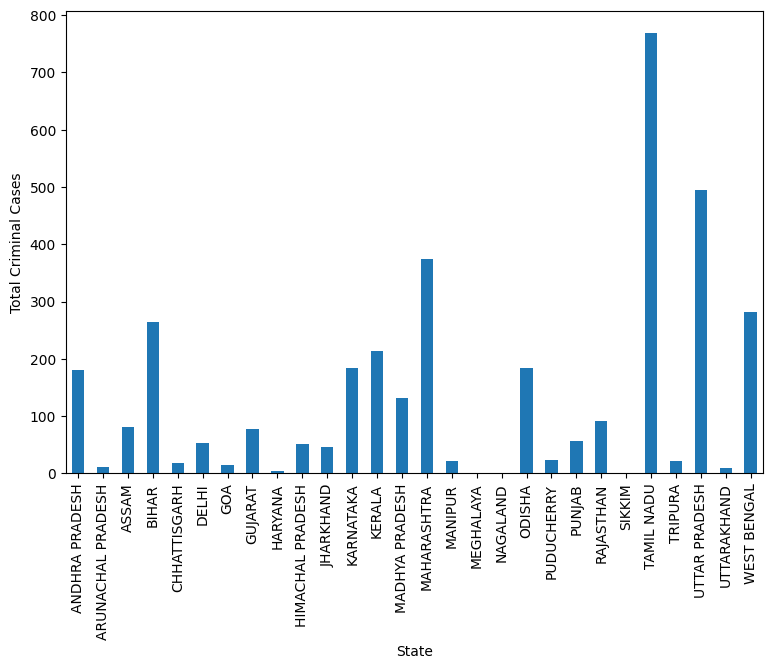

In [21]:
# Total criminal cases in each party
plt.figure(figsize=(9,6))
df_train.groupby('state')['Criminal Case'].sum().plot(kind='bar')
plt.xlabel('State')
plt.ylabel('Total Criminal Cases')
plt.savefig('Images/criminal_cases_state.png')
plt.show()

##### Average Criminal Case per candidate in each State

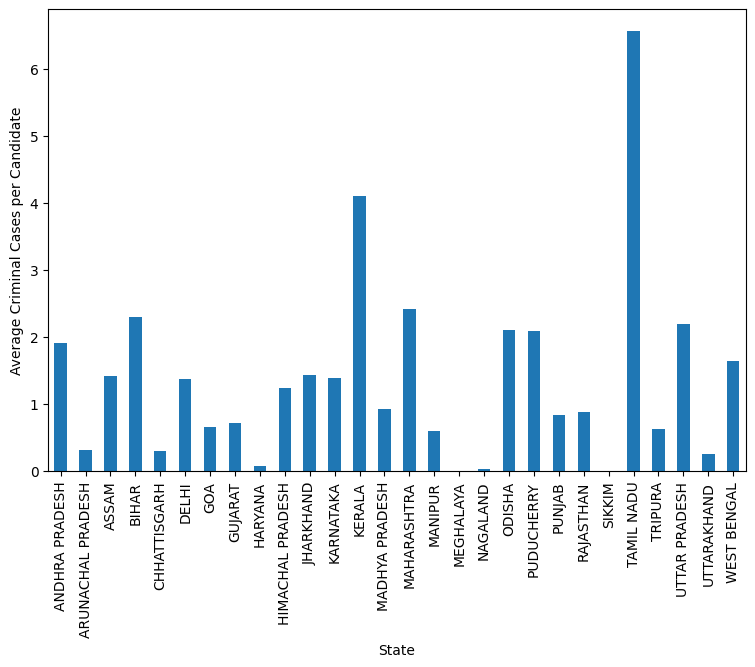

In [22]:
# Total criminal case in each party
plt.figure(figsize=(9,6))
df_train.groupby('state')['Criminal Case'].mean().plot(kind='bar')
plt.xlabel('State')
plt.ylabel('Average Criminal Cases per Candidate')
plt.savefig('Images/avg_criminal_cases_state.png')
plt.show()

##### Candidates having more than 3 criminal cases by state

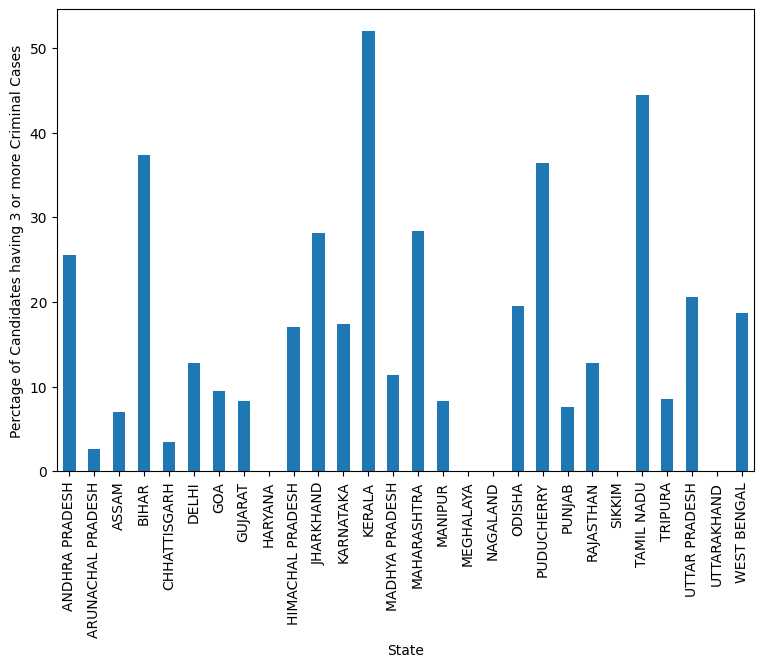

In [23]:
total_person_byparty = df_train.groupby('state')['Candidate'].count()
data = df_train[df_train['Criminal Case'] >= 3].groupby('state')['Criminal Case'].count()
data = data/total_person_byparty * 100

plt.figure(figsize=(9,6))
data.plot(kind='bar')
plt.xlabel('State')
plt.ylabel('Perctage of Candidates having 3 or more Criminal Cases')
plt.savefig('Images/more_than_3_criminal_state.png')
plt.show()


## Analysing Rich Candidates

#### By Party

In [24]:
total_income = (df_train['Total Assets'] - df_train['Liabilities']).mean()
rich_income = total_income * 5
print(rich_income)

470042243.5648373


In [25]:
rich_income = 50000000

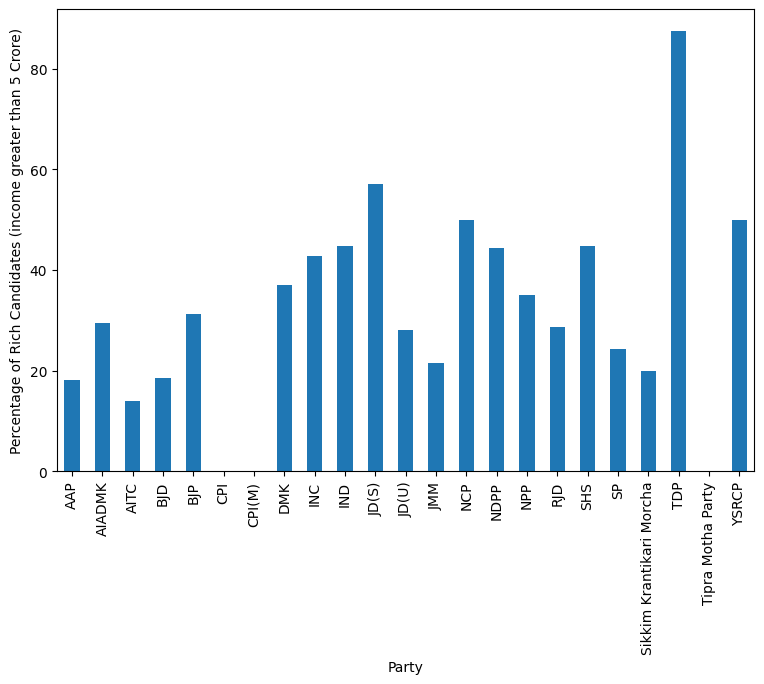

In [26]:
#plot percentage of candidates having income grater rich income grouped by each party
rich_person_byparty = df_train[(df_train['Total Assets'] - df_train['Liabilities']) >= rich_income].groupby('Party')['Candidate'].count()

#find the percentage of rich candidates in each party and plot
total_person_byparty = df_train.groupby('Party')['Candidate'].count()
percentage_rich_person = rich_person_byparty/total_person_byparty * 100

#plot using matplotlib
plt.figure(figsize=(9,6))
percentage_rich_person.plot(kind='bar')
plt.xlabel('Party')
plt.ylabel('Percentage of Rich Candidates (income greater than 5 Crore)')
plt.savefig('Images/percentage_rich_candidates_party.png')
plt.show()

#### By State

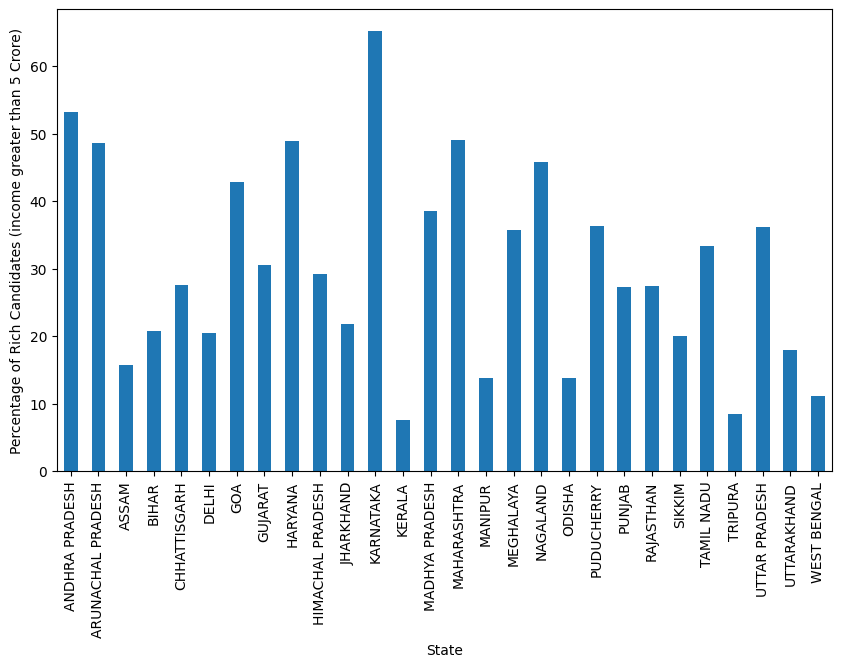

In [27]:
rich_person_bystate = df_train[(df_train['Total Assets'] - df_train['Liabilities']) >= rich_income].groupby('state')['Candidate'].count()

#find the percentage of rich candidates in each party and plot
total_person_bystate = df_train.groupby('state')['Candidate'].count()
percentage_rich_person = rich_person_bystate/total_person_bystate * 100

#plot using matplotlib
plt.figure(figsize=(10,6))
percentage_rich_person.plot(kind='bar')
plt.xlabel('State')
plt.ylabel('Percentage of Rich Candidates (income greater than 5 Crore)')
plt.savefig('Images/percentage_rich_candidates_state.png')
plt.show()

## Analysing Education Distribution

In [66]:
df_education = df_train.copy()

df_education['Education'] = df_education['Education'].apply(encode_label)
df_education['Education Category'] = df_education['Education'].apply(edu_category)

#### By Party wise category

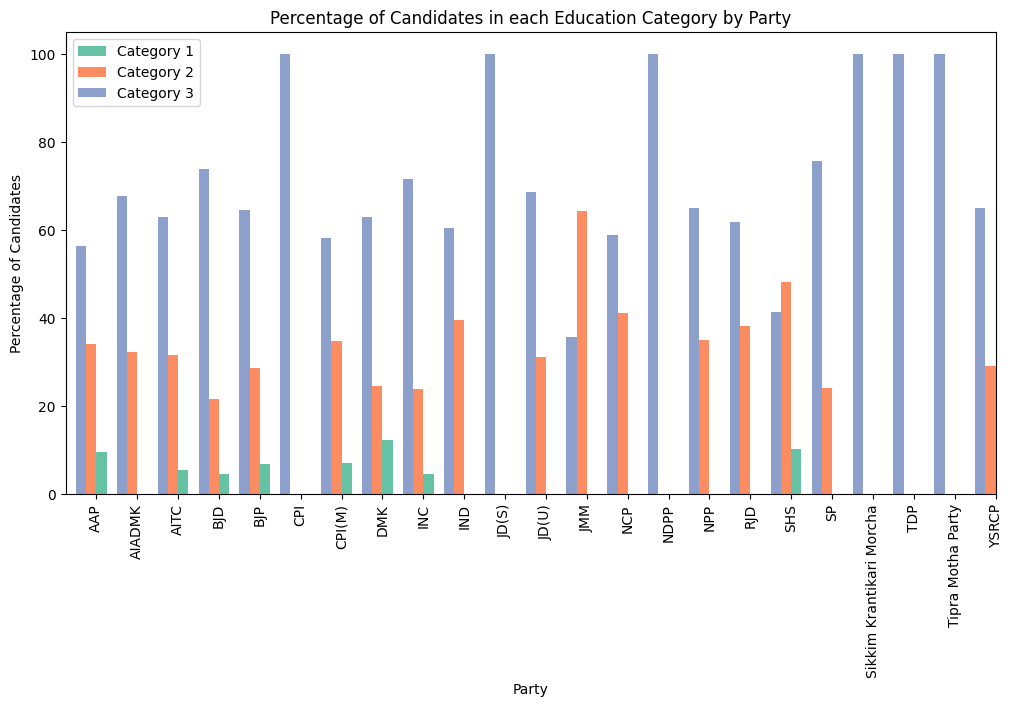

In [67]:
cat_1 = df_education[df_education["Education Category"] == "1"].groupby('Party')['Candidate'].count()
total_person_byparty = df_train.groupby('Party')['Candidate'].count()
percent_cat_1 = cat_1/total_person_byparty * 100

cat_2 = df_education[df_education["Education Category"] == "2"].groupby('Party')['Candidate'].count()
percent_cat_2 = cat_2/total_person_byparty * 100

cat_3 = df_education[df_education["Education Category"] == "3"].groupby('Party')['Candidate'].count()
percent_cat_3 = cat_3/total_person_byparty * 100


plt.figure(figsize=(12, 6))
#now show the plots in a single plot
percent_cat_1.plot(kind='bar', color='#66c2a5', position=0, width=0.25)
percent_cat_2.plot(kind='bar', color='#fc8d62', position=1, width=0.25)
percent_cat_3.plot(kind='bar', color='#8da0cb', position=2, width=0.25)

plt.xlabel('Party')
plt.ylabel('Percentage of Candidates')
plt.legend(['Category 1', 'Category 2', 'Category 3'])
plt.title('Percentage of Candidates in each Education Category by Party')
plt.savefig('Images/percentage_education_category_party.png')
plt.show()


#### By state wise category

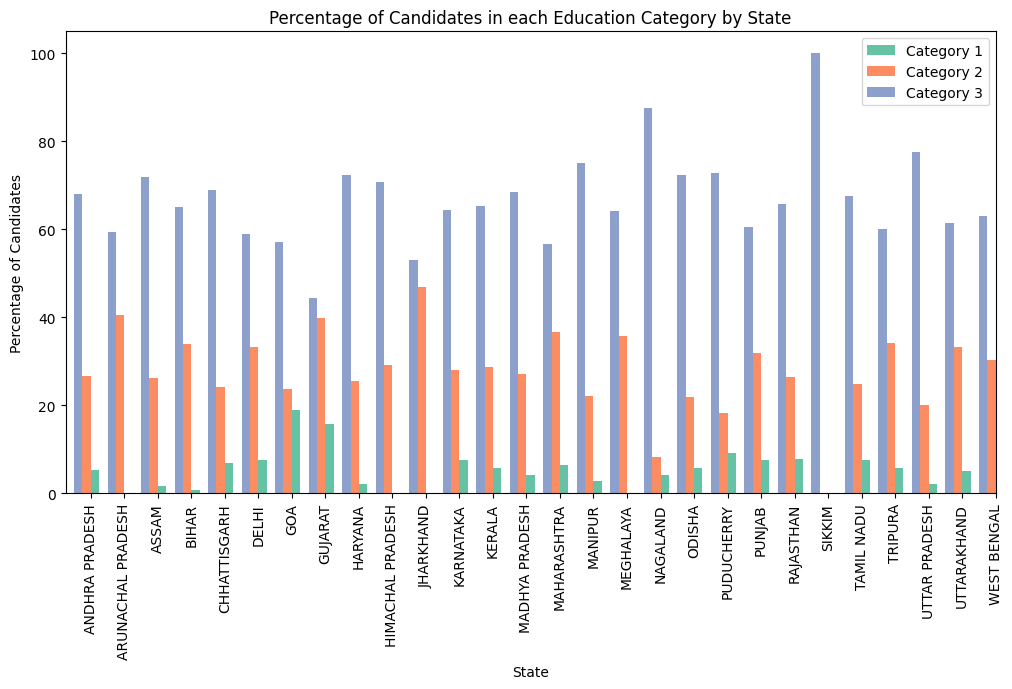

In [68]:
cat_1 = df_education[df_education["Education Category"] == "1"].groupby('state')['Candidate'].count()
total_person_bystate = df_train.groupby('state')['Candidate'].count()
percent_cat_1 = cat_1/total_person_bystate * 100

cat_2 = df_education[df_education["Education Category"] == "2"].groupby('state')['Candidate'].count()
percent_cat_2 = cat_2/total_person_bystate * 100

cat_3 = df_education[df_education["Education Category"] == "3"].groupby('state')['Candidate'].count()
percent_cat_3 = cat_3/total_person_bystate * 100


plt.figure(figsize=(12, 6))
#now show the plots in a single plot
percent_cat_1.plot(kind='bar', color='#66c2a5', position=0, width=0.25)
percent_cat_2.plot(kind='bar', color='#fc8d62', position=1, width=0.25)
percent_cat_3.plot(kind='bar', color='#8da0cb', position=2, width=0.25)

plt.xlabel('State')
plt.ylabel('Percentage of Candidates')
plt.legend(['Category 1', 'Category 2', 'Category 3'])
plt.title('Percentage of Candidates in each Education Category by State')
plt.savefig('Images/percentage_education_category_state.png')
plt.show()


8th Pass


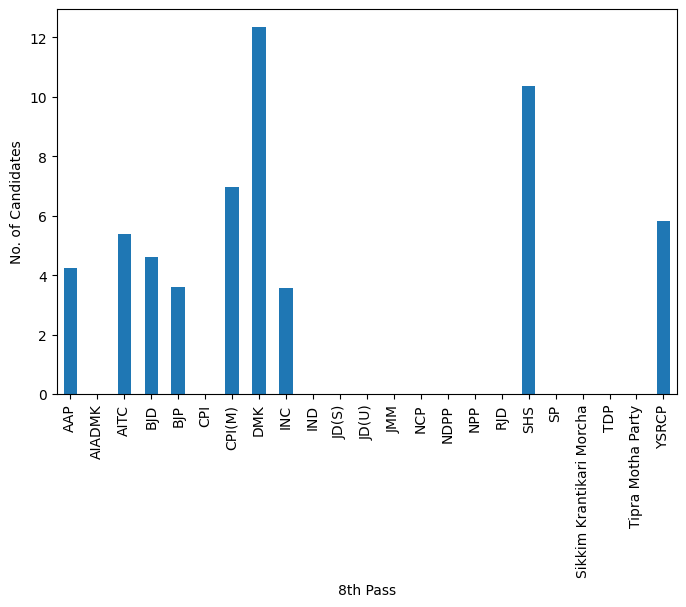

12th Pass


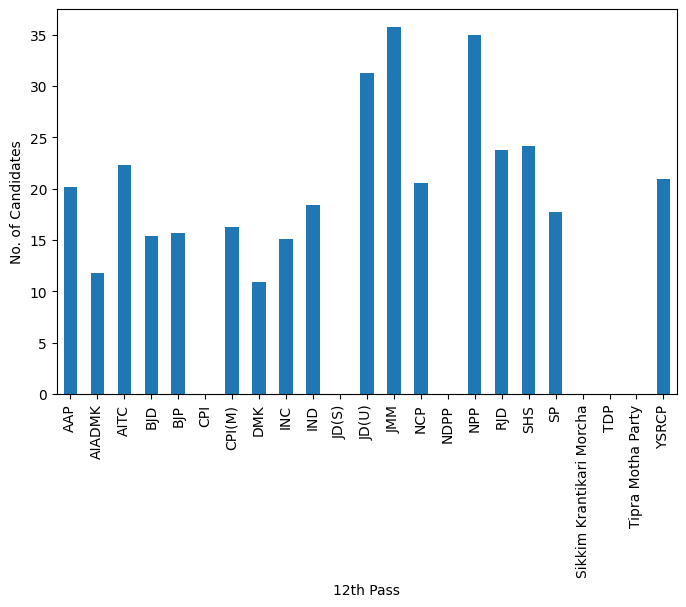

Post Graduate


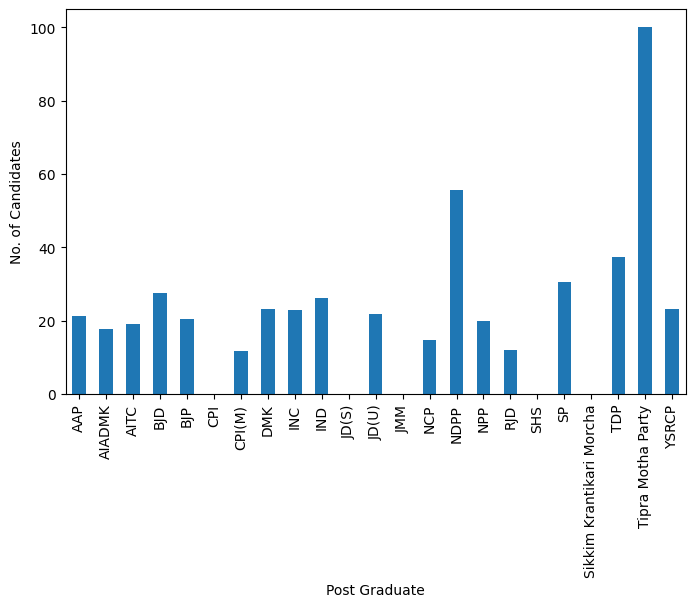

Graduate Professional


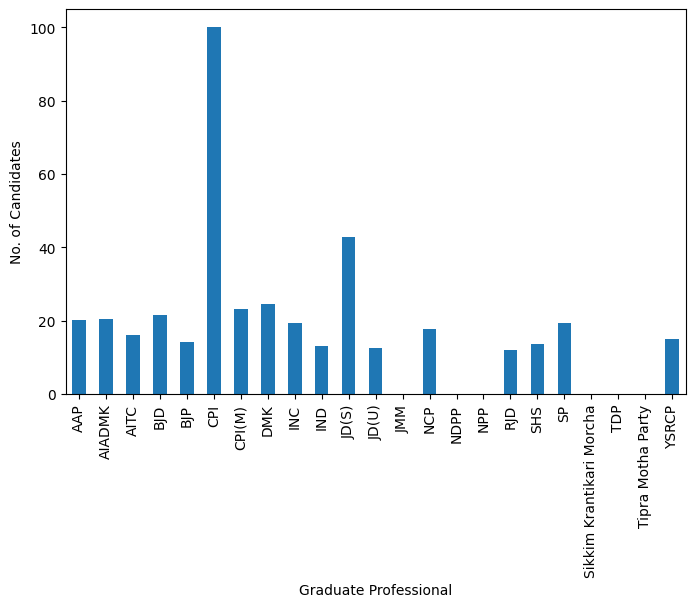

Graduate


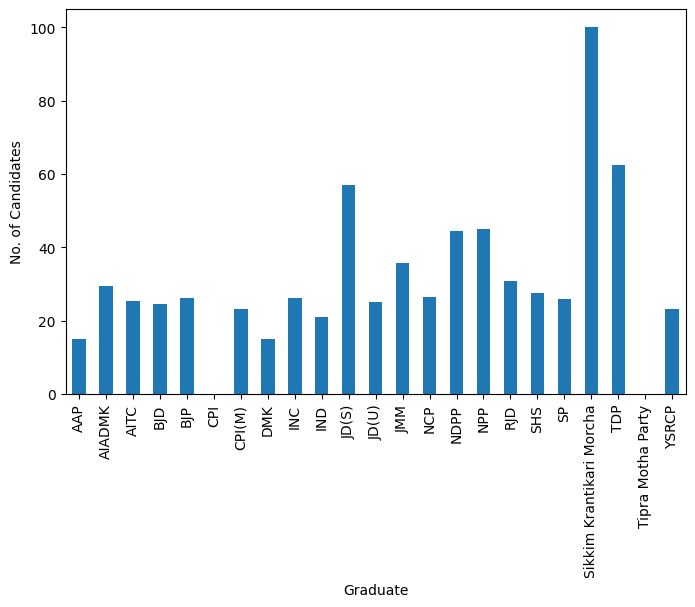

10th Pass


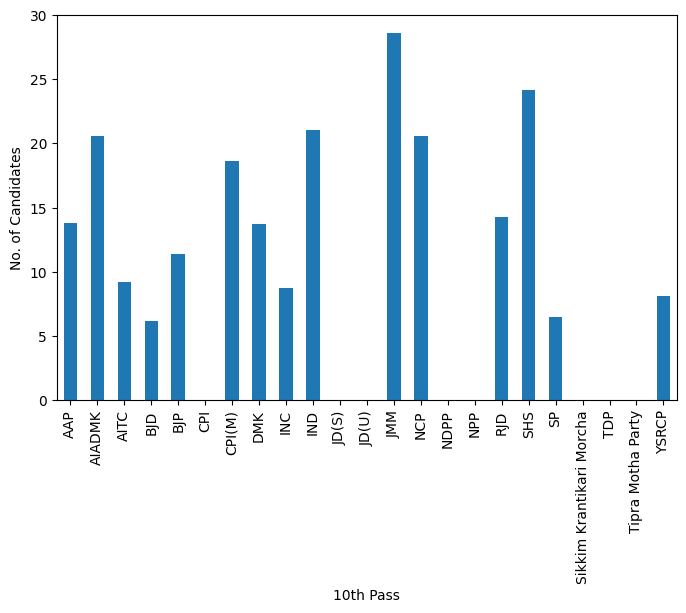

Others


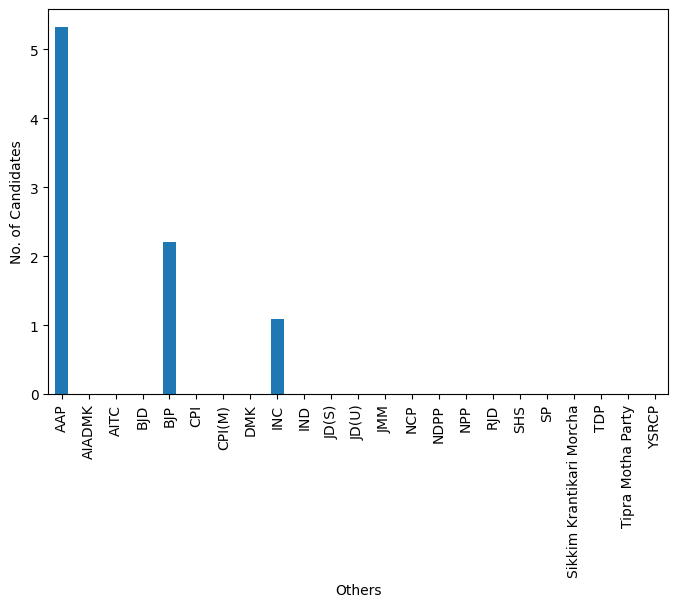

Doctorate


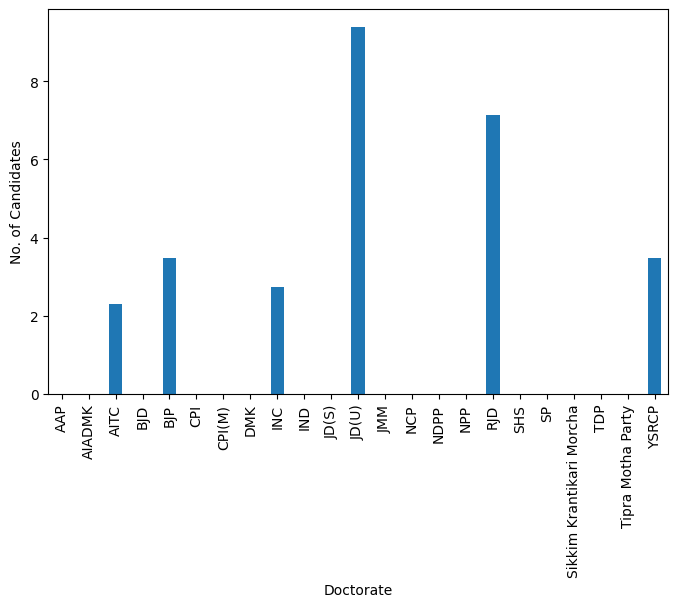

Literate


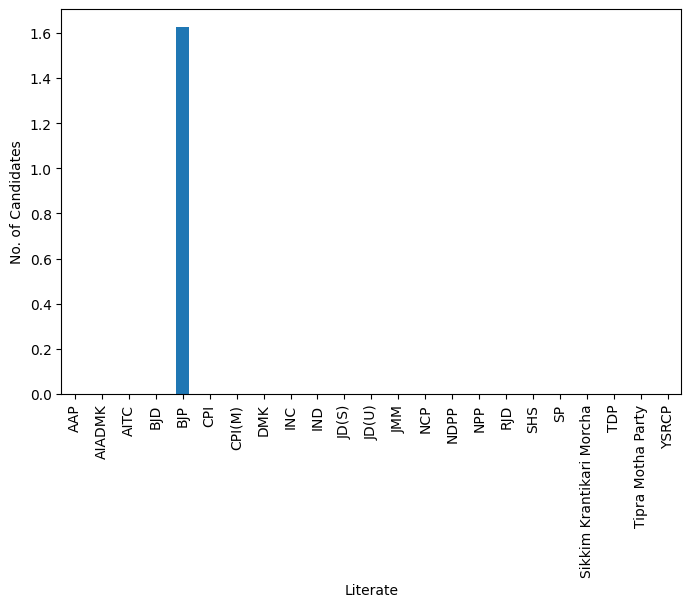

5th Pass


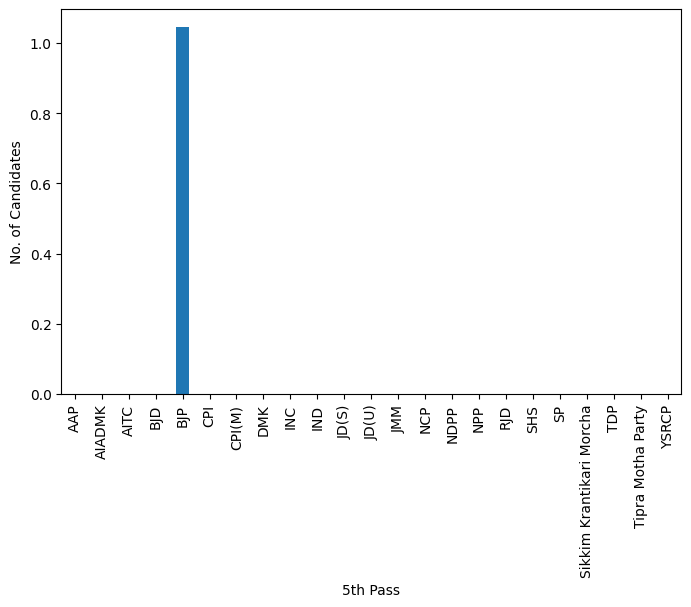

In [28]:
# get data where Education is Graduate
total_person_byparty = df_train.groupby('Party')['Candidate'].count()

for i in df_train['Education'].unique():
    print(i)
    plt.figure(figsize=(8,5))
    df_train_graduate = df_train[df_train['Education'] == i]
    
    percentage_edu = df_train_graduate['Party'].value_counts() / total_person_byparty * 100
    percentage_edu.plot(kind='bar')
    plt.xlabel(i)
    plt.ylabel('No. of Candidates')
    plt.show()

In [29]:
df_train['Party'].value_counts()

Party
BJP                         862
INC                         365
AITC                        130
AAP                          94
YSRCP                        86
DMK                          73
BJD                          65
SP                           62
CPI(M)                       43
RJD                          42
IND                          38
NCP                          34
AIADMK                       34
JD(U)                        32
SHS                          29
NPP                          20
JMM                          14
NDPP                          9
TDP                           8
JD(S)                         7
Sikkim Krantikari Morcha      5
CPI                           4
Tipra Motha Party             3
Name: count, dtype: int64

# Preprocessing

##### Assets and Liabilities were converted to numerical value in the beginning

#### Identify labels from Name

In [30]:
is_dr = df_train['Candidate'].apply(lambda x: 'Dr.' in x)
is_prof = df_train['Candidate'].apply(lambda x: 'Prof.' in x)
is_adv = df_train['Candidate'].apply(lambda x: 'Adv.' in x)

In [31]:
df_train['is_dr'] = is_dr
df_train['is_prof'] = is_prof
df_train['is_adv'] = is_adv

#### Identify SC and ST from Constituency

In [32]:
is_st = df_train['Constituency ∇'].apply(lambda x: '(ST)' in x )
is_sc = df_train['Constituency ∇'].apply(lambda x: '(SC)' in x )

In [33]:
df_train['is_st'] = is_st
df_train['is_sc'] = is_sc

#### Apply Discretizer

In [34]:
# Apply discretizer

discretizer = KBinsDiscretizer(n_bins=10, encode='ordinal', strategy='uniform')

df_train['Total Assets'] = discretizer.fit_transform(df_train[['Total Assets']])
df_train['Liabilities'] = discretizer.fit_transform(df_train[['Liabilities']])
df_train['Criminal Case'] = discretizer.fit_transform(df_train[['Criminal Case']])

/Users/mridulgupta/anaconda3/envs/MachineLearning/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:248: FutureWarning: In version 1.5 onwards, subsample=200_000 will be used by default. Set subsample explicitly to silence this warning in the mean time. Set subsample=None to disable subsampling explicitly.
  warnings.warn(
/Users/mridulgupta/anaconda3/envs/MachineLearning/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:248: FutureWarning: In version 1.5 onwards, subsample=200_000 will be used by default. Set subsample explicitly to silence this warning in the mean time. Set subsample=None to disable subsampling explicitly.
  warnings.warn(
/Users/mridulgupta/anaconda3/envs/MachineLearning/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:248: FutureWarning: In version 1.5 onwards, subsample=200_000 will be used by default. Set subsample explicitly to silence this warning in the mean time. Set subsample=None to disable subsam

In [35]:
df_train['Party'].unique()

array(['DMK', 'BJP', 'INC', 'AITC', 'AAP', 'SP', 'NPP', 'BJD', 'IND',
       'SHS', 'RJD', 'YSRCP', 'AIADMK', 'CPI(M)', 'NCP', 'TDP', 'NDPP',
       'CPI', 'Sikkim Krantikari Morcha', 'JD(U)', 'JMM', 'JD(S)',
       'Tipra Motha Party'], dtype=object)

In [36]:
#convert columns to integer
parties_train = df_train['Party'].unique()
states_train = df_train['state'].unique()


#### One-hot encode Party and State

In [37]:
#one hot encode party and state
df_train_encoded = pd.get_dummies(df_train, columns=['Party','state'])
df_train_encoded.head()

,ID,Candidate,Constituency ∇,Criminal Case,Total Assets,Liabilities,Education,is_dr,is_prof,is_adv,...,state_ODISHA,state_PUDUCHERRY,state_PUNJAB,state_RAJASTHAN,state_SIKKIM,state_TAMIL NADU,state_TRIPURA,state_UTTAR PRADESH,state_UTTARAKHAND,state_WEST BENGAL
0,0,M.K. Mohan,ANNA NAGAR,0.0,1.0,0.0,8th Pass,False,False,False,...,False,False,False,False,False,True,False,False,False,False
1,1,Khatik Ramesh Prasad,KARERA (SC),0.0,0.0,0.0,12th Pass,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,2,Dr. Mantar Gowda,MADIKERI,0.0,0.0,0.0,Post Graduate,True,False,False,...,False,False,False,False,False,False,False,False,False,False
3,3,Kundan Kumar,BEGUSARAI,0.0,0.0,0.0,Post Graduate,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,4,Swapan Majumder,BANGAON DAKSHIN (SC),0.0,0.0,0.0,8th Pass,False,False,False,...,False,False,False,False,False,False,False,False,False,True


In [38]:
df_train_encoded['Education'].value_counts()

Education
Graduate                 531
Post Graduate            432
12th Pass                349
Graduate Professional    339
10th Pass                227
8th Pass                  78
Doctorate                 52
Others                    28
Literate                  14
5th Pass                   9
Name: count, dtype: int64

#### Identify Outliers

In [59]:
def detect_outliers(df):
    z_scores = (df - df.mean()) / df.std()
    outlier_indices = z_scores.abs() > 3
    return outlier_indices.any(axis=1)

In [60]:
outlier_indices = detect_outliers(df_train_encoded[['Total Assets', 'Liabilities', 'Criminal Case']])
df_train_encoded['is_outlier'] = False
df_train_encoded.loc[outlier_indices, 'is_outlier'] = True


In [39]:
df_train_encoded.drop(['ID','Candidate', 'Constituency ∇'],inplace=True,axis=1)

In [40]:
df_train_encoded.head()

,Criminal Case,Total Assets,Liabilities,Education,is_dr,is_prof,is_adv,is_st,is_sc,Party_AAP,...,state_ODISHA,state_PUDUCHERRY,state_PUNJAB,state_RAJASTHAN,state_SIKKIM,state_TAMIL NADU,state_TRIPURA,state_UTTAR PRADESH,state_UTTARAKHAND,state_WEST BENGAL
0,0.0,1.0,0.0,8th Pass,False,False,False,False,False,False,...,False,False,False,False,False,True,False,False,False,False
1,0.0,0.0,0.0,12th Pass,False,False,False,False,True,False,...,False,False,False,False,False,False,False,False,False,False
2,0.0,0.0,0.0,Post Graduate,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,0.0,0.0,0.0,Post Graduate,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,0.0,0.0,0.0,8th Pass,False,False,False,False,True,False,...,False,False,False,False,False,False,False,False,False,True


In [41]:
df_train['Education'].value_counts()

Education
Graduate                 531
Post Graduate            432
12th Pass                349
Graduate Professional    339
10th Pass                227
8th Pass                  78
Doctorate                 52
Others                    28
Literate                  14
5th Pass                   9
Name: count, dtype: int64

#### Apply label encoding accordign to edu value

In [42]:
labels = ['5th Pass', '8th Pass', 'Others','10th Pass', '12th Pass', 'Literate',
          'Graduate', 'Graduate Professional', 'Post Graduate', 'Doctorate']

# Corresponding encoded values
encoded_values = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

# Create a dictionary mapping labels to encoded values
label_encoding_dict = dict(zip(labels, encoded_values))

# Function to encode a single label
def encode_label(label):
    return label_encoding_dict[label]

def decode_label(encoded_value):
    return labels[encoded_value]

In [43]:
def edu_category(value):
    if value == 0 or value == 1 or value == 2:
        return '1'
    elif value == 3 or value == 4 or value == 5:
        return '2'
    elif value == 6 or value == 7 or value == 8 or value == 9: 
        return '3'

In [44]:
df_train_encoded['Education'] = df_train_encoded['Education'].apply(encode_label)
# df_train_encoded['Education Category'] = df_train_encoded['Education'].apply(edu_category)

In [45]:
# df_train_encoded = pd.get_dummies(df_train_encoded, columns=['Education Category'])

In [46]:
df_train_encoded.head()

,Criminal Case,Total Assets,Liabilities,Education,is_dr,is_prof,is_adv,is_st,is_sc,Party_AAP,...,state_ODISHA,state_PUDUCHERRY,state_PUNJAB,state_RAJASTHAN,state_SIKKIM,state_TAMIL NADU,state_TRIPURA,state_UTTAR PRADESH,state_UTTARAKHAND,state_WEST BENGAL
0,0.0,1.0,0.0,1,False,False,False,False,False,False,...,False,False,False,False,False,True,False,False,False,False
1,0.0,0.0,0.0,4,False,False,False,False,True,False,...,False,False,False,False,False,False,False,False,False,False
2,0.0,0.0,0.0,8,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,0.0,0.0,0.0,8,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,0.0,0.0,0.0,1,False,False,False,False,True,False,...,False,False,False,False,False,False,False,False,False,True


# Model Analysis

In [47]:
# sklearn train test split, drop education
X= df_train_encoded.drop(['Education'],axis=1)
y = df_train_encoded['Education']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.head()

,Criminal Case,Total Assets,Liabilities,is_dr,is_prof,is_adv,is_st,is_sc,Party_AAP,Party_AIADMK,...,state_ODISHA,state_PUDUCHERRY,state_PUNJAB,state_RAJASTHAN,state_SIKKIM,state_TAMIL NADU,state_TRIPURA,state_UTTAR PRADESH,state_UTTARAKHAND,state_WEST BENGAL
266,0.0,0.0,0.0,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False
1133,0.0,0.0,0.0,False,False,False,True,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1823,0.0,0.0,0.0,False,False,False,False,False,False,False,...,False,False,False,True,False,False,False,False,False,False
1370,0.0,0.0,0.0,False,False,False,True,False,False,False,...,False,False,False,False,False,False,False,False,False,False
67,0.0,0.0,0.0,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [48]:
# Define the classifiers
classifiers = {
    "Logistic Regression": LogisticRegression(C=120, max_iter=10000,),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(n_estimators=56, max_features='log2', random_state=67, ),
    "SVM": SVC(C=120),
    "GaussianNB": GaussianNB(),
    "Knn" : KNeighborsClassifier(),
    "BernoulliNB": BernoulliNB(alpha=0.2, binarize=0.0,fit_prior=True,class_prior=None),
    "MultinomialNB": MultinomialNB(alpha = 0.99, fit_prior = True),
    "ComplementNB": ComplementNB(),
    "AdaBoost": AdaBoostClassifier(n_estimators=60, random_state=67),
}

# Fit the classifiers and print the accuracy
for name, clf in classifiers.items():
    for epoch in range(2):
        clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(f"{name} Accuracy: {accuracy_score(y_test, y_pred)}")

Logistic Regression Accuracy: 0.25
Decision Tree Accuracy: 0.2354368932038835
Random Forest Accuracy: 0.24029126213592233
SVM Accuracy: 0.24757281553398058
GaussianNB Accuracy: 0.08009708737864078
Knn Accuracy: 0.21601941747572814
BernoulliNB Accuracy: 0.23786407766990292
MultinomialNB Accuracy: 0.24757281553398058
ComplementNB Accuracy: 0.24029126213592233
AdaBoost Accuracy: 0.12378640776699029


/Users/mridulgupta/anaconda3/envs/MachineLearning/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/mridulgupta/anaconda3/envs/MachineLearning/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


In [49]:
from sklearn.metrics import f1_score

# Calculate the F1 score for each classifier
for name, clf in classifiers.items():
    y_pred = clf.predict(X_test)
    print(f"{name} F1 Score: {f1_score(y_test, y_pred, average='weighted')}")
    # print(pd.Series(y_pred).value_counts())

Logistic Regression F1 Score: 0.20985911320473788
Decision Tree F1 Score: 0.21358054551326308
Random Forest F1 Score: 0.20955413872502726
SVM F1 Score: 0.2135105056067592
GaussianNB F1 Score: 0.08223898830975115
Knn F1 Score: 0.20245998341357932
BernoulliNB F1 Score: 0.21308086893851214
MultinomialNB F1 Score: 0.21142277853272778
ComplementNB F1 Score: 0.23090368414753304
AdaBoost F1 Score: 0.11519665911531042


In [50]:
model_bnb = BernoulliNB(alpha=0.5, binarize=0.0,fit_prior=True,class_prior=None)

In [51]:
model_bnb.fit(X_train, y_train)

BernoulliNB(alpha=0.5)

In [ ]:


# Define the hyperparameters to tune
param_grid = {
    'n_estimators': list(range(1,101)),
    'max_features': ['sqrt', 'log2'],
    'max_depth' : [None],
    'criterion' :['gini', 'entropy'],
    'random_state': list(range(1,101)),
}

# Instantiate the grid search model
rf = RandomForestClassifier()
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, cv = 3, n_jobs = -1, verbose = 2,scoring='f1_weighted')
grid_search.fit(X_train, y_train)


In [ ]:
print(grid_search.best_params_)
print(grid_search.best_score_)

In [ ]:
param_grid = {
    'n_neighbors': [i for i in range(1,20)],
    'weights': ['uniform', 'distance'],
    'algorithm' : ['ball_tree', 'kd_tree', 'brute'],
    'leaf_size' : [10, 20, 30, 40, 50]
}

In [ ]:
knn = KNeighborsClassifier()
grid_search = GridSearchCV(estimator = knn, param_grid = param_grid, cv = 3, n_jobs = -1, verbose = 2,scoring='f1_weighted')
grid_search.fit(X_train, y_train)

In [ ]:
print(grid_search.best_params_)
print(grid_search.best_score_)

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

# Define the classifiers
classifiers = {
    "Logistic Regression": LogisticRegression(C=120, max_iter=10000,),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(n_estimators=60, max_features='log2', random_state=67, ),
    "SVM": SVC(C=120),
    "GaussianNB": GaussianNB(),
    "Knn" : KNeighborsClassifier()
}

# Fit the classifiers and print the accuracy
for name, clf in classifiers.items():
    for epoch in range(2):
        clf.fit(X_train, y_encoded)
    y_pred = [ decode_label(label) for label in clf.predict(X_test) ]
    print(f"{name} Accuracy: {accuracy_score(y_test, y_pred)}")

In [ ]:
from sklearn.metrics import f1_score

# Calculate the F1 score for each classifier
for name, clf in classifiers.items():
    y_pred = [ decode_label(label) for label in clf.predict(X_test) ]
    print(f"{name} F1 Score: {f1_score(y_test, y_pred, average='weighted')}")
    # print(pd.Series(y_pred).value_counts())
    



# Final Model Submission

In [51]:
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

In [52]:
def preprocessing(df):
    df_encoded = pd.get_dummies(df, columns=['Party', 'state'])
    df['Liabilities'] = [convert_to_numerical(liability) for liability in df['Liabilities']]
    df['Total Assets'] = [convert_to_numerical(asset) for asset in df['Total Assets'] ]
    
    #Converting labels from name
    df_encoded["is_dr"] = df['Candidate'].apply(lambda x: 'Dr.' in x)
    df_encoded["is_adv"] = df['Candidate'].apply(lambda x: 'Adv.' in x)
    df_encoded["is_prof"] = df['Candidate'].apply(lambda x: 'Prof.' in x)
    
    #Extractign labels from constituency
    df_encoded['is_sc'] = df_encoded['Constituency ∇'].apply(lambda x: '(SC)' in x)
    df_encoded['is_st'] = df_encoded['Constituency ∇'].apply(lambda x: '(ST)' in x)
    
    #Apply discretizer on assets and liabilites
    discretizer = KBinsDiscretizer(n_bins=10, encode='ordinal', strategy='uniform')

    df_encoded['Total Assets'] = discretizer.fit_transform(df[['Total Assets']])
    df_encoded['Liabilities'] = discretizer.fit_transform(df[['Liabilities']])
    df_encoded['Criminal Case'] = discretizer.fit_transform(df[['Criminal Case']])
    
    return df_encoded.drop(['Candidate', 'Constituency ∇',], axis=1)

In [53]:
df_train_X = preprocessing(df_train.drop('Education', axis=1))
df_train_y = df_train['Education']

/Users/mridulgupta/anaconda3/envs/MachineLearning/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:248: FutureWarning: In version 1.5 onwards, subsample=200_000 will be used by default. Set subsample explicitly to silence this warning in the mean time. Set subsample=None to disable subsampling explicitly.
  warnings.warn(
/Users/mridulgupta/anaconda3/envs/MachineLearning/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:248: FutureWarning: In version 1.5 onwards, subsample=200_000 will be used by default. Set subsample explicitly to silence this warning in the mean time. Set subsample=None to disable subsampling explicitly.
  warnings.warn(
/Users/mridulgupta/anaconda3/envs/MachineLearning/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:248: FutureWarning: In version 1.5 onwards, subsample=200_000 will be used by default. Set subsample explicitly to silence this warning in the mean time. Set subsample=None to disable subsam

In [54]:
df_test_new = preprocessing(df_test)
df_test_new.head()

/Users/mridulgupta/anaconda3/envs/MachineLearning/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:248: FutureWarning: In version 1.5 onwards, subsample=200_000 will be used by default. Set subsample explicitly to silence this warning in the mean time. Set subsample=None to disable subsampling explicitly.
  warnings.warn(
/Users/mridulgupta/anaconda3/envs/MachineLearning/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:248: FutureWarning: In version 1.5 onwards, subsample=200_000 will be used by default. Set subsample explicitly to silence this warning in the mean time. Set subsample=None to disable subsampling explicitly.
  warnings.warn(
/Users/mridulgupta/anaconda3/envs/MachineLearning/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:248: FutureWarning: In version 1.5 onwards, subsample=200_000 will be used by default. Set subsample explicitly to silence this warning in the mean time. Set subsample=None to disable subsam

,ID,Criminal Case,Total Assets,Liabilities,Party_AAP,Party_AIADMK,Party_AITC,Party_BJD,Party_BJP,Party_CPI,...,state_TAMIL NADU,state_TRIPURA,state_UTTAR PRADESH,state_UTTARAKHAND,state_WEST BENGAL,is_dr,is_adv,is_prof,is_sc,is_st
0,0,0.0,0.0,0.0,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,1,0.0,0.0,0.0,False,False,True,False,False,False,...,False,False,False,False,True,False,False,False,False,False
2,2,0.0,0.0,0.0,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,3,0.0,0.0,0.0,False,False,True,False,False,False,...,False,False,False,False,True,False,False,False,False,False
4,4,0.0,0.0,0.0,False,False,False,False,False,False,...,False,False,True,False,False,False,False,False,False,False


In [55]:
model = MultinomialNB(alpha = 0.99, fit_prior = True)
model.fit(df_train_X, df_train_y)

MultinomialNB(alpha=0.99)

In [56]:
y_pred = pd.DataFrame(model.predict(df_test_new), columns=['Education'])

In [57]:
y_pred.value_counts()

Education            
Graduate                 635
Post Graduate            334
Graduate Professional    175
12th Pass                120
10th Pass                 70
Doctorate                 19
Others                    13
5th Pass                   7
8th Pass                   1
Name: count, dtype: int64

In [58]:

# Save to CSV
y_pred.to_csv('output.csv', index=True, index_label='ID')
